- [ ] Symmetry exploitation
- [ ] Code augmentation
- [ ] Sample obtention
*************************

## Define the Environment
The environment consists of **states**, **actions**, and **rewards**. States and actions are inputs for the Q-learning AI agent, while the possible actions are the AI agent's outputs.
#### States
The states in the environment are all of the possible locations within the 17x17 field. 


**Q-Learning - Exploiting rotational and mirror symmetries**

> The game board looks the same if we rotate it by 90, 180, or 270 degrees, and when flipped horizontally or vertically. 
> 
> > Thus, if an optimal move is to go "up" in one state configuration, it might be optimal to go "right" in a state that is rotated 90 degrees.


> >
>




This helps reduce the `q_table.size()` and provides better generalization of the agent from fewer samples. We will use this to create more training samples, making learning more robust.

**_A. Defining the transformations_**

In [1]:
import numpy as np

In [2]:
def rotate_arena(field: np.ndarray, angle: int) -> np.ndarray:
    """
    Rotate the field by the given angle (must be a multiple of 90 degrees).

    :param field: The 2D numpy array representing the game field.
    :param angle: The angle to rotate (must be one of 90, 180, 270).
    :return: The rotated game field.
    """
    # Check if angle is a multiple of 90
    if angle % 90 != 0:
        raise ValueError("Angle must be a multiple of 90 degrees")
    else:
        k = angle // 90
        return np.rot90(field, k)


In [45]:
def rotate_positions(positions: list, angle: int, field_shape: tuple) -> list:
    """
    Rotate the positions of coins by the specified angle.
    
    :param positions: A dictionary of coin positions where keys are coin IDs and values are (x, y) tuples.
    :param angle: The angle to rotate (must be one of 90, 180, 270).
    :param field_shape: The shape of the field (ROWS, COLS).
    :return: A dictionary of rotated positions.
    """
    rows, cols = field_shape
    
    if angle == 90:
        rotated_positions = [(y, cols - 1 - x) for (x, y) in positions]
    elif angle == 180:
        rotated_positions = [(rows - 1 - x, cols - 1 - y) for (x, y) in positions]
    elif angle == 270:
        rotated_positions = [(rows - 1 - y, x) for (x, y) in positions]
    else:
        raise ValueError("Angle must be 90, 180, or 270 degrees.")
    
    return rotated_positions


In [4]:
def flip_arena(field: np.ndarray, direction: str) -> np.ndarray:
    """
    Flip the game field (arena) horizontally or vertically.
    
    :param field: The 2D numpy array representing the game field.
    :param direction: The direction to flip ('horizontal' or 'vertical').
    :return: The flipped game field.
    """
    
    if direction == 'horizontal':
        return np.flip(field, 1)
    elif direction == 'vertical':
        return np.flip(field, 0)
    else:
        raise ValueError("Direction must be either 'horizontal' or 'vertical'.")


In [46]:
def flip_positions(positions: list, direction: str, field_shape: tuple) -> list:
    """
    Rotate the positions of coins by the specified angle.
    
    :param positions: A dictionary of coin positions where keys are coin IDs and values are (x, y) tuples.
    :param direction: The direction to flip ('horizontal' or 'vertical').
    :param field_shape: The shape of the field (ROWS, COLS).
    :return: A dictionary of flipped positions.
    """
    flipped_positions = []
    rows, cols = field_shape
    
    if direction == 'horizontal':
        flipped_positions = [(x, cols - 1 - y) for (x, y) in positions]
    elif direction == 'vertical':
        flipped_positions = [(rows - 1 - x, y) for (x, y) in positions]
        
    else:
        raise ValueError("Direction must be either 'horizontal' or 'vertical'.")

    return flipped_positions
    


In [6]:
import pygame 
from items import Item
import numpy as np
import matplotlib.pyplot as plt
import settings as Settings

class Coin(Item):
    avatar = pygame.image.load(Settings.ASSET_DIR / 'coin.png')

    def __init__(self, pos, collectable=False):
        super(Coin, self).__init__()
        self.x = pos[0]
        self.y = pos[1]
        self.collectable = collectable

    def get_state(self):
        return self.x, self.y


pygame 2.6.0 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [47]:
# Define a simple game world class to render the board
import numpy as np
from numpy import random

class SimpleBombRLWorld:
    def __init__(self):
        self.rng = np.random.default_rng()
        self.arena, self.coin_positions, self.crate_positions = self.build_arena()
        
    def build_arena(self):
        WALL = -1
        FREE = 0
        CRATE = 1
        CRATE_DENSITY = 0.75
        arena = np.zeros((Settings.COLS, Settings.ROWS), int)

        # Crates in random locations
        arena[self.rng.random((Settings.COLS, Settings.ROWS)) < CRATE_DENSITY] = CRATE

        # Walls
        arena[:1, :] = WALL
        arena[-1:, :] = WALL
        arena[:, :1] = WALL
        arena[:, -1:] = WALL
        for x in range(Settings.COLS):
            for y in range(Settings.ROWS):
                if (x + 1) * (y + 1) % 2 == 1:
                    arena[x, y] = WALL

        # Clean the start positions
        start_positions = [(1, 1), (1, Settings.ROWS - 2), (Settings.COLS - 2, 1), (Settings.COLS - 2, Settings.ROWS - 2)]
        for (x, y) in start_positions:
            for (xx, yy) in [(x, y), (x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]:
                if arena[xx, yy] == 1:
                    arena[xx, yy] = FREE

        # Place coins at random, at preference under crates
        coins = []
        all_positions = np.stack(np.meshgrid(np.arange(Settings.COLS), np.arange(Settings.ROWS), indexing="ij"), -1)
        crate_positions = self.rng.permutation(all_positions[arena == CRATE])
        free_positions = self.rng.permutation(all_positions[arena == FREE])
        coin_positions = np.concatenate([
            crate_positions,
            free_positions
        ], 0)[:50]
        for x, y in coin_positions:
            coins.append(Coin((x, y), collectable=arena[x, y] == FREE))
    
        return arena, coin_positions, crate_positions

    def rotate(self, angle: int):
        if angle not in [90, 180, 270]:
            raise ValueError("Angle must be one of 90, 180, 270.")
        
        self.arena = rotate_arena(self.arena, angle)
        self.coin_positions = rotate_positions(self.coin_positions, angle, self.arena.shape)
        self.crate_positions = rotate_positions(self.crate_positions, angle, self.arena.shape)

    def get_state(self):
        return self.arena, self.coin_positions, self.crate_positions



In [48]:
# Define a simple game renderer class to render the board
class GameRenderer:
    def __init__(self, world):
        self.world = world
        pygame.init()
        
        # Calculate the size of the board based on grid size and offsets
        board_width = Settings.GRID_SIZE * Settings.COLS
        board_height = Settings.GRID_SIZE * Settings.ROWS
        
        # Set the Pygame window size to match the board size
        self.screen = pygame.display.set_mode((board_width, board_height))
        pygame.display.set_caption('BombeRLe Board Renderer')

        # Colors
        self.bg_color = (255, 182, 193)  # Background color for the board only
        self.wall_color = (255, 105, 180) 
        self.crate_color = (255, 192, 203)  
        self.coin_color = (255, 215, 0)  
        self.coin_text_color = (0, 0, 0) 

        # Create surfaces for rendering tiles
        self.t_wall = pygame.Surface((Settings.GRID_SIZE, Settings.GRID_SIZE))
        self.t_wall.fill(self.wall_color)
        self.t_crate = pygame.Surface((Settings.GRID_SIZE, Settings.GRID_SIZE))
        self.t_crate.fill(self.crate_color)
        self.t_coin = pygame.Surface((Settings.GRID_SIZE, Settings.GRID_SIZE))
        self.t_coin.fill(self.coin_color)

    def render(self):
        # Fill the board area with the background color
        self.screen.fill((0, 0, 0))  # Fill the entire screen with black
        pygame.draw.rect(self.screen, self.bg_color, (0, 0, self.screen.get_width(), self.screen.get_height()))

        arena, coins, crates = self.world.get_state()
        
        # Draw arena (walls and crates)
        for x in range(arena.shape[1]):
            for y in range(arena.shape[0]):
                if arena[x, y] == -1:
                    self.screen.blit(self.t_wall, (Settings.GRID_SIZE * x, Settings.GRID_SIZE * y))
                elif arena[x, y] == 1:
                    self.screen.blit(self.t_crate, (Settings.GRID_SIZE * x, Settings.GRID_SIZE * y))

        # Draw crates
        for (x, y) in crates:
            self.screen.blit(self.t_crate, (Settings.GRID_SIZE * x, Settings.GRID_SIZE * y))

        # Draw coins
        for i, (x, y) in enumerate(coins):
            self.screen.blit(self.t_coin, (Settings.GRID_SIZE * x, Settings.GRID_SIZE * y))
            # Draw coin number
            font = pygame.font.Font(None, 15)
            text = font.render(str(i), True, self.coin_text_color)
            self.screen.blit(text, (Settings.GRID_SIZE * x + 5, Settings.GRID_SIZE * y + 5))
        
        # Draw grid lines (adjusted to match the board)
        grid_color = (255, 105, 180)  # Hot pink grid lines
        
        # Draw vertical grid lines
        for x in range(Settings.COLS + 1):
            pygame.draw.line(
                self.screen, grid_color, 
                (x * Settings.GRID_SIZE, 0), 
                (x * Settings.GRID_SIZE, Settings.ROWS * Settings.GRID_SIZE), 1
            )
        # Draw horizontal grid lines
        for y in range(Settings.ROWS + 1):
            pygame.draw.line(
                self.screen, grid_color, 
                (0, y * Settings.GRID_SIZE), 
                (Settings.COLS * Settings.GRID_SIZE, y * Settings.GRID_SIZE), 1
            )

        pygame.display.flip()


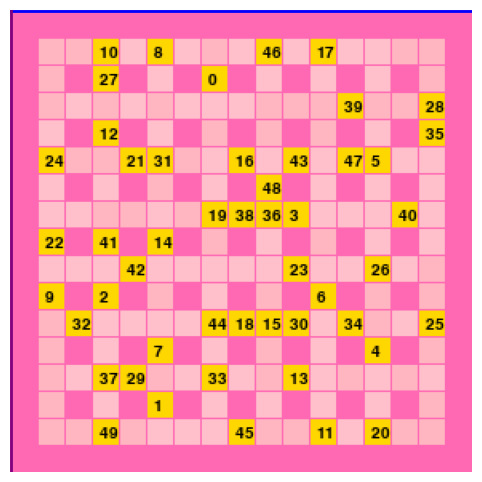

In [49]:
world = SimpleBombRLWorld()
renderer = GameRenderer(world)

# Render the board
renderer.render()

# Display the result in the Jupyter Notebook
def pygame_to_matplotlib():
    pygame.display.flip()
    data = pygame.surfarray.array3d(renderer.screen)
    plt.figure(figsize=(Settings.WIDTH / 100, Settings.HEIGHT / 100), dpi=100)
    plt.imshow(data.swapaxes(0, 1))
    plt.axis('off')
    
    # Add axes with lines (1, 0) blue and (0, 1) purple
    ax = plt.gca()
    ax.axhline(y=0, color='blue', linestyle='-', linewidth=2)
    ax.axvline(x=0, color='purple', linestyle='-', linewidth=2)

    plt.show()

pygame_to_matplotlib()

# Clean up
pygame.quit()

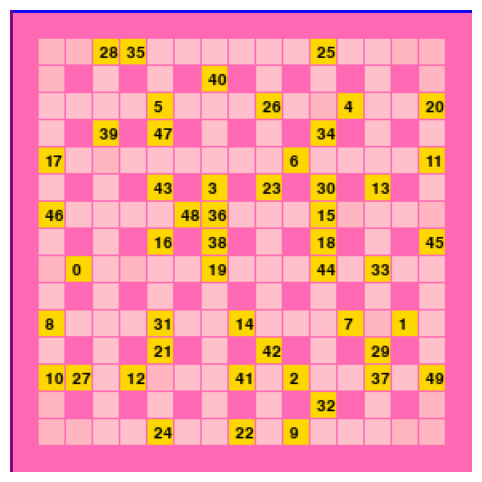

In [52]:
print(world.crate_positions)
renderer = GameRenderer(world)
renderer.render()

pygame_to_matplotlib()

# Clean up
pygame.quit()

**_B. Normalizing states_**

We generate all rotated (90°, 180°, 270°) and reflected versions of the state. Then, we choose a Canonical State: for example, the lexicographically smallest or largest state representation could serve as the canonical form.
That way we store only the Canonical State in the Q-Table: whenever a new state is encountered during training or gameplay, it is first converted to its canonical form before being stored or queried in the Q-table. This ensures all equivalent states map to the same entry.

In [53]:
import hashlib

class StateHasher:
    def __init__(self):
        self.state_cache = {}  # Dictionary to store unique states and their canonical forms

    def serialize_state(self, arena, coins, agents, bombs, explosions):
        """
        Serializes the game state components into a unique string representation.
        """
        # Serialize arena as a flattened string
        arena_str = np.array2string(arena.flatten(), separator=',')
        
        # Serialize coins as a sorted tuple of positions
        coins_str = ','.join(f"({x},{y})" for x, y in sorted(coins))
        
        # Serialize agents (simplified to positions for now, can add more details as needed)
        agents_str = ','.join(f"({a.x},{a.y})" for a in sorted(agents, key=lambda a: (a.x, a.y)))
        
        # Serialize bombs as positions and timers
        bombs_str = ','.join(f"({b.x},{b.y},{b.timer})" for b in sorted(bombs, key=lambda b: (b.x, b.y, b.timer)))
        
        # Serialize explosions as positions and timers
        explosions_str = ','.join(f"({x},{y},{timer})" for x, y, timer in sorted(explosions, key=lambda e: (e[0], e[1], e[2])))
        
        # Combine all serialized parts into a single string
        state_str = f"{arena_str}|{coins_str}|{agents_str}|{bombs_str}|{explosions_str}"
        
        return state_str

    def hash_state(self, state_str):
        """
        Generates a unique hash for a serialized state string.
        """
        return hashlib.sha256(state_str.encode('utf-8')).hexdigest()

    def get_canonical_state(self, state):
        """
        Checks if a state or its canonical form already exists.
        If not, it computes and stores the canonical form.
        """
        # Extract components from the state
        arena = state['field']
        coins = [(coin.x, coin.y) for coin in state['coins']]
        agents = state['others']  # This would be a list of agent objects
        bombs = state['bombs']  # List of bomb objects with position and timer
        explosions = [(x, y, timer) for x, y, timer in state['explosion_map']]  # explosion_map could be a list of coordinates with timers
        
        # Serialize the state
        serialized_state = self.serialize_state(arena, coins, agents, bombs, explosions)
        
        # Get the hash of the serialized state
        state_hash = self.hash_state(serialized_state)
        
        # Check if the state already exists in the cache
        if state_hash in self.state_cache:
            return self.state_cache[state_hash]  # Return the cached canonical state
        
        # Compute the canonical state if it does not exist
        canonical_state = self.compute_canonical_state(state)  # This would involve applying all rotations and symmetries
        
        # Serialize and hash the canonical state
        serialized_canonical_state = self.serialize_state(
            canonical_state['field'], 
            [(coin.x, coin.y) for coin in canonical_state['coins']], 
            canonical_state['others'], 
            canonical_state['bombs'], 
            [(x, y, timer) for x, y, timer in canonical_state['explosion_map']]
        )
        canonical_hash = self.hash_state(serialized_canonical_state)
        
        # Cache the canonical form
        self.state_cache[state_hash] = canonical_hash
        self.state_cache[canonical_hash] = canonical_state
        
        return canonical_state

    def compute_canonical_state(self, state):
        """
        Computes the canonical form of the state by considering all possible symmetries (rotations and reflections).
        """
        # Placeholder: Implement the logic to generate all rotations and reflections and pick the canonical form
        # Could use a lexicographic minimum or some other rule to choose the canonical form
        return state  # For now, we return the state unchanged




In [ ]:
# Example usage:
state_hasher = StateHasher()
arena = world.arena
coins = world.coin_positions
agents = []  # Placeholder list of agents
bombs = []  # Placeholder list of bombs
explosions = []  # Placeholder list of explosions

# Mock state example
mock_state = {
    'field': arena,
    'coins': coins,
    'others': agents,
    'bombs': bombs,
    'explosion_map': explosions
}

# Get canonical state
canonical_state = state_hasher.get_canonical_state(mock_state)
print("Canonical State:", canonical_state)

**__C. Canonical form in the Q_Table__**

-------

In [ ]:
import numpy as np
import networkx as nx
import events as e
from json import dump as json_dump
from pickle import dump as pickle_dump
from typing import List, Dict, Tuple

In [11]:
import sys
import os

# Add the path to the 'agents' folder
sys.path.append(os.path.abspath(os.path.join('agent_code')))

from my_agent.callbacks import state_to_features, act, setup


TypeError: setup() missing 1 required positional argument: 'self'

In [ ]:
# Training parameters
num_episodes = 1000  # Number of games to play
max_steps_per_episode = 100  # Maximum steps per game/episode

# Initialize the model
setup()

for episode in range(num_episodes):
    game_state = initialize_game()  # Reset the game environment at the start of each episode
    state = c.state_to_features(game_state)
    
    for step in range(max_steps_per_episode):
        # Choose action
        action = c.choose_action(state, q_table, epsilon)
        
        # Perform the action in the environment (get new state and events)
        new_game_state, events = c.act(game_state, action)
        next_state = c.state_to_features(new_game_state)
        
        # Get the reward
        reward = reward_from_events(events)
        
        # Update the Q-table
        t.update_q_table(q_table, state, action, reward, next_state, alpha, gamma)
        
        # Transition to the next state
        state = next_state
        
        # Check if game is over (adjust condition based on your game)
        if t.is_game_over(new_game_state):
            break
    
    # Optional: Decay epsilon over time to reduce exploration as training progresses
    epsilon = max(0.01, epsilon * 0.995)

print("Training completed!")


In [ ]:
def train(self):
    for episode in range(self.num_episodes):
    game_state = reset_game()  # Reset environment at the start of each episode
    total_reward = 0
    
    for step in range(self.max_steps):
        action = self.agent.act(game_state)  # Get action from the agent
        next_state, reward, done = execute_action(action)  # Execute the action
        
        # Store the experience and update the model
        self.store_experience(game_state, action, reward, next_state)
        self.agent.model.update(game_state, action, reward, next_state)
        
        total_reward += reward
        game_state = next_state
        
        if done:
            break  # End episode if the game is over
    
    self.rewards.append(total_reward)  # Log reward for this episode
    self.log_training_progress(episode)

In [ ]:
def is_terminal_state(current_row_index, current_column_index):
  """
  Define if we are in terminal state.

  :param current_row_index 
  """
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
  if rewards[current_row_index, current_column_index] == -1.:
    return False
  else:
    return True

#define a function that will choose a random, non-terminal starting location
def get_starting_location():
  #get a random row and column index
  current_row_index = np.random.randint(Settings.ROWS)
  current_column_index = np.random.randint(Settings.COLS)
  #continue choosing random row and column indexes until a non-terminal state is identified
  #(i.e., until the chosen state is a 'white square').
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(Settings.ROWS)
    current_column_index = np.random.randint(Settings.COLS)
  return current_row_index, current_column_index

#define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon,
  #then choose the most promising value from the Q-table for this state.
  if np.random.random() < epsilon:
    return np.argmax(q_values[current_row_index, current_column_index])
  else: #choose a random action
    return np.random.randint(4)

#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < Settings.COLS - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < Settings.ROWS - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

#Define a function that will get the shortest path between any location within the warehouse that
#the robot is allowed to travel and the item packaging location.
def get_shortest_path(start_row_index, start_column_index):
  #return immediately if this is an invalid starting location
  if is_terminal_state(start_row_index, start_column_index):
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the item packaging location)
    while not is_terminal_state(current_row_index, current_column_index):
      #get the best action to take
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
    return shortest_path

#### Train the AI Agent using Q-Learning

In [ ]:
#define training parameters
epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards
learning_rate = 0.9 #the rate at which the AI agent should learn

#run through 1000 training episodes
for episode in range(1000):
  #get the starting location for this episode
  row_index, column_index = get_starting_location()

  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the item packaging area or crash into an item storage location)
  while not is_terminal_state(row_index, column_index):
    #choose which action to take (i.e., where to move next)
    action_index = get_next_action(row_index, column_index, epsilon)

    #perform the chosen action, and transition to the next state (i.e., move to the next location)
    old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
    row_index, column_index = get_next_location(row_index, column_index, action_index)

    #receive the reward for moving to the new state, and calculate the temporal difference
    reward = rewards[row_index, column_index]
    old_q_value = q_values[old_row_index, old_column_index, action_index]
    temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

    #update the Q-value for the previous state and action pair
    new_q_value = old_q_value + (learning_rate * temporal_difference)
    q_values[old_row_index, old_column_index, action_index] = new_q_value

print('Training complete!')

## Get Shortest Paths
Now that the AI agent has been fully trained, we can see what it has learned by displaying the shortest path between any location in the warehouse where the robot is allowed to travel and the item packaging area.


In [ ]:
#display a few shortest paths
print(get_shortest_path(3, 9)) #starting at row 3, column 9
print(get_shortest_path(5, 0)) #starting at row 5, column 0
print(get_shortest_path(9, 5)) #starting at row 9, column 5